In [17]:
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import pandas_ta as ta
import quantstats as qs
qs.extend_pandas()

import numpy as np
import datetime
from tqdm import tqdm
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
from arch import arch_model

params = {'figure.facecolor': 'w'}
plt.rcParams.update(params)

from IPython.display import display

import warnings
from statsmodels.tools.sm_exceptions import ValueWarning
warnings.simplefilter('ignore', ValueWarning)
warnings.simplefilter('ignore', FutureWarning)
warnings.simplefilter('ignore', UserWarning)

## Helper Functions

In [ ]:
def tsplot(y, lags=None, figsize=(20, 8), style='bmh', title='Time Series Analysis Plots'):
    # source: http://www.blackarbs.com/blog/time-series-analysis-in-python-linear-models-to-garch/11/1/2016#GARCH
    
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        qq_ax = plt.subplot2grid(layout, (2, 0))
        pp_ax = plt.subplot2grid(layout, (2, 1))
        
        y.plot(ax=ts_ax)
        ts_ax.set_title(title)
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05, zero=False, auto_ylims=True)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05, zero=False, auto_ylims=True)
        sm.qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot')        
        scs.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)

        plt.tight_layout()
    return 

## Data Preparation

### Data Loading

In [18]:
# Data Directory
data_dir = '/workspace/202205_idx-trading/_data/'
crypto_dir = '/workspace/202205_idx-trading/_data/20220610_binance-crypto/'
binance50_crypto_list = '20220610_binance-top50-crypto-list.txt'

# Prepare Crypto Tickers
with open(data_dir + binance50_crypto_list, "r") as f:
    crypto_tickers = f.read().split('\n')
    
## Remove Crypto Tickers that are newly added (2021>)
rmv_crypto_tickers = ['APEBUSD', 'FLOWBUSD', 'FTTBUSD', 'HNTBUSD', 
                     'THETABUSD', 'ICPBUSD', 'SHIBBUSD', 'TUSDBUSD',
                     'AXSBUSD']
active_tickers = [x for x in crypto_tickers if x not in rmv_crypto_tickers]

In [19]:
# Read downloaded crypto Adjusted Close price data
df_dict = {}
for ticker in tqdm(active_tickers):
    df_dict[ticker] = pd.read_csv(crypto_dir + ticker + '.csv')
    
    ## Take Only Date and Adjusted Close
    df_dict[ticker] = df_dict[ticker][['Date', 'Adj Close']]
    
    ## Convert Adj Close to Returns
    df_dict[ticker]['return'] = df_dict[ticker]['Adj Close'].pct_change()
    df_dict[ticker]['log_return'] = np.log(1 + df_dict[ticker]['return'])
    df_dict[ticker].drop('Adj Close', axis=1, inplace=True)

100%|████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 44.11it/s]


In [21]:
# Do Some basic data Operations 
## - Standardize Starting Dates
## - Fill NaN
## - Take only certain data range
## - Generate in sample an dout of sample data

# Assume that Starting Date is available in all tickers
date_start = '2021-01-01'
date_breakpoint = '2022-01-01'

nan_handle_method = 'drop'

in_df = {}
out_df = {}
rmv_tickers = []
for ticker in tqdm(active_tickers):
    # Fill NaN values with the earliest data
    if nan_handle_method == 'bfill':
        df_dict[ticker].fillna(method='bfill', axis=0, inplace=True)
    elif nan_handle_method == 'drop':
        df_dict[ticker].dropna(inplace=True)
    
    # Take In Sample and Out Sample Data from certain ranges
    df_dict[ticker]['Date'] = pd.to_datetime(df_dict[ticker]['Date'])
    in_df[ticker] = df_dict[ticker][(df_dict[ticker]['Date'] >= date_start) & 
                                                (df_dict[ticker]['Date'] < date_breakpoint)]
    out_df[ticker] = df_dict[ticker][df_dict[ticker]['Date'] >= date_breakpoint]
    
    # Set Date as Index
    in_df[ticker] = in_df[ticker].reset_index(drop=True)
    in_df[ticker] = in_df[ticker].set_index('Date')
    out_df[ticker] = out_df[ticker].reset_index(drop=True)
    out_df[ticker] = out_df[ticker].set_index('Date')
    
    # Check if in_df is empty
    if len(in_df[ticker]['return']) < 252:
        rmv_tickers.append(ticker)

# Remove tickers that only have small amounts of data
active_tickers = [t for t in active_tickers if t not in rmv_tickers]      

100%|████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 42.25it/s]


## Data Exploration
We will test for cointegration on in-sample data

In [30]:
from statsmodels.tsa.stattools import coint

def find_coint_pairs(df_dict, tickers, plot=True, alpha=0.05):
    '''
    Finds cointegrated pairs from df_dict serial data, based on given tickers.
    '''
    n = len(tickers)
    score_matrix = np.zeros((n, n))
    pvalue_matrix = np.ones((n, n))
    pairs = []
    pvalues = []
    
    for i in tqdm(range(0, n)):
        for j in range(i+1, n):
            S1 = df_dict[tickers[i]]['Close']
            S2 = df_dict[tickers[j]]['Close']
            result = coint(S1, S2)
            score = result[0]
            pvalue = result[1]
            score_matrix[i, j] = score
            pvalue_matrix[i, j] = pvalue
            if pvalue < alpha:
                pairs.append([tickers[i], tickers[j]])
                pvalues.append(pvalue)
                
    if plot:
        seaborn.heatmap(pvalue_matrix, xticklabels=tickers, yticklabels=tickers, cmap='RdYlGn_r'
                    , mask = (pvalue_matrix >= alpha)
                    )
                
    return score_matrix, pvalue_matrix, pairs, pvalues

100%|████████████████████████████████████████████████████████████████████| 32/32 [00:23<00:00,  1.35it/s]


[['BTCBUSD', 'DOTBUSD'], ['LTCBUSD', 'LINKBUSD'], ['LTCBUSD', 'XLMBUSD'], ['LTCBUSD', 'UNIBUSD'], ['LINKBUSD', 'XLMBUSD'], ['EOSBUSD', 'BCHBUSD'], ['EOSBUSD', 'FILBUSD'], ['XLMBUSD', 'UNIBUSD'], ['BCHBUSD', 'UNIBUSD'], ['BCHBUSD', 'FILBUSD'], ['ATOMBUSD', 'ALGOBUSD'], ['ALGOBUSD', 'EGLDBUSD'], ['AVAXBUSD', 'NEARBUSD']]


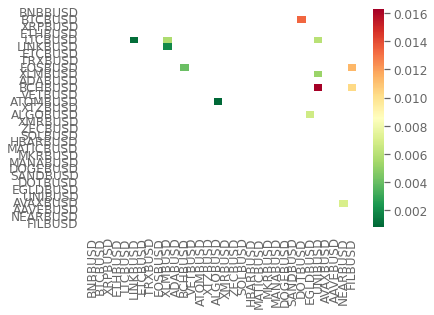

In [31]:
# Explore Cointegration
tickers = active_tickers
_, pval_mat, pairs, pvalues = find_coint_pairs(in_df, tickers, alpha=0.02)
print(pairs)

In [32]:
# List of Cointegrated Pairs 
coint_pairs = pairs

In [35]:
import statsmodels.api as sm

def calc_beta(S1, S2):
    '''
    Calculate beta from two price series by doing regression.
    '''
    S1 = sm.add_constant(S1)
    results = sm.OLS(S2, S1).fit()
    S1 = S1['Close']
    b = results.params['Close']
    
    return b

def calc_half_life(S):
    '''
    Calculate half life from a price series
    '''
    S_lag = S.shift(periods=1).iloc[1:]
    S_diff = S.iloc[1:] - S_lag

    S_lag = sm.add_constant(S_lag)
    results = sm.OLS(S_diff, S_lag).fit()
    S_lag = S_lag['Close']
    lbd = results.params['Close']

    half_life = -np.log(2) / lbd
    
    return lbd, half_life

In [36]:
# Calculate Half Life for All Pairs

pair_df = pd.DataFrame(columns=['ticker_1', 'ticker_2', 'beta', 'lambda', 'half_life'])
for pair in tqdm(coint_pairs):
    # Regression to get Beta for Price Spread Model
    S1 = in_df[pair[0]]['Close']
    S2 = in_df[pair[1]]['Close']
    b = calc_beta(S1, S2)
    spread = S2 - b * S1
    
    # Ornstein-Uhlenbeck Formula to Calculate Half Life
    lbd, half_life = calc_half_life(spread)
    
    # Append to df
    buff = pd.DataFrame({"ticker_1": [pair[0]],
                          "ticker_2": [pair[1]],
                          "beta": [b],
                          "lambda": [lbd],
                          "half_life": [half_life]})
    pair_df = pd.concat([pair_df, buff])

pair_df = pair_df.reset_index(drop=True)

display(pair_df)

100%|████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 19.72it/s]


,ticker_1,ticker_2,beta,lambda,half_life
0,BTCBUSD,DOTBUSD,0.000982,-0.07945,8.724265
1,LTCBUSD,LINKBUSD,0.134749,-0.120702,5.742635
2,LTCBUSD,XLMBUSD,0.00189,-0.087946,7.881526
3,LTCBUSD,UNIBUSD,0.116045,-0.05145,13.472204
4,LINKBUSD,XLMBUSD,0.013263,-0.120201,5.766544
5,EOSBUSD,BCHBUSD,110.100117,-0.144787,4.78735
6,EOSBUSD,FILBUSD,18.114206,-0.055612,12.463921
7,XLMBUSD,UNIBUSD,56.660073,-0.058947,11.758883
8,BCHBUSD,UNIBUSD,0.029224,-0.062104,11.160989
9,BCHBUSD,FILBUSD,0.140371,-0.029614,23.406272


## Strategy

### Baseline Strategy

Buy and Hold BTC

In [37]:
# Simple buy and hold strategy
b_df = out_df['BTCBUSD'].copy()

b_df['signal'] = ''
b_df['close'] = b_df['Close']
b_df = b_df[['Date', 'close', 'signal']]
b_df = b_df.reset_index(drop=True)

b_df['signal'][0] = 'buy'
b_df['signal'][len(b_df)-1] = 'sell'

def calc_returns_benchmark(df):
    '''
    Calculate returns and cumulative returns per entry on dataframe.
    Used for benchmark calculation.
    '''
    df_proc = df.copy()
    
    last_signal = ''
    df_proc['return'] = np.nan
    for i in range(0, len(df_proc)):
        if last_signal == 'buy':
            df_proc["return"][i] = (df_proc['close'][i] - df_proc['close'][i-1]) / df_proc['close'][i-1]
        elif last_signal == 'sell':
            df_proc["return"][i] = 0
        else:
            df_proc["return"][i] = 0
        
        if not(df_proc["signal"][i] == ''):
            last_signal = df_proc["signal"][i] 

    df_proc["cum_return"] = (1 + df_proc["return"]).cumprod()
    return df_proc

### Trading Strategy
Simple Bollinger Band-based long only strategy adapted from:
https://github.com/quantopian/research_public/blob/master/notebooks/lectures/Introduction_to_Pairs_Trading/notebook.ipynb

Since the original is a long-short strategy, we can only use part of the strategy, which is just long one part of the pair.

Alternatively, we can long the other part of the pair during "short the spread" but this is flawed.

In [38]:
from statsmodels.regression.rolling import RollingOLS

def strategy(df_dict, pair, lookback, beta_lookback=30, std=1):
    '''
    Long-Only Bollinger Band Mean Reversion Strategy
    
    1. Calculate the Rolling Price Spread, by first estimating the beta model of the pair.
       We assume the model is of the form Y = beta * X where Y is the second item in the pair.
    2. Calculate the BBands
    3. Generate Signal, based on BBand (long when price >= bbl, exit when price <= bbm)
    4. Calculate Returns
    
    '''
    
    # Take the relevant price series from each pair
    df_proc = pd.concat([df_dict[pair[0]]['Date'], df_dict[pair[0]]['Close'], df_dict[pair[1]]['Close']], 
                            axis=1,
                            keys=['Date', pair[0], pair[1]])
    
    # Calculate Rolling Price Spread using Beta Model
    S1 = df_proc[pair[0]]
    S2 = df_proc[pair[1]]
    
    S1_indep = sm.add_constant(S1)
    result = RollingOLS(S2, S1_indep, window=beta_lookback).fit()
    rolling_beta = result.params[pair[0]]
    
    ## add Rolling Beta to main df
    df_proc['beta'] = rolling_beta
    
    ## calculate rolling spread
    df_proc['spread'] = df_proc[pair[1]] - df_proc['beta'] * df_proc[pair[0]]
    
    # Generate Technical Indicators (BBand and SMA)
    df_proc.set_index('Date')
    #sma = ta.sma(df_proc['spread'], length=lookback)
    bbands = ta.bbands(df_proc['spread'], length=lookback, std=std)
    
    bbands_upper_cname = 'BBU' + '_' + str(lookback) + '_' + str(std) + '.0'
    bbands_lower_cname = 'BBL' + '_' + str(lookback) + '_' + str(std) + '.0'
    bbands_mid_cname = 'BBM' + '_' + str(lookback) + '_' + str(std) + '.0'
    
    #df_proc['spread_SMA'] = sma
    df_proc['spread_BBU'] = bbands[bbands_upper_cname]
    df_proc['spread_BBL'] = bbands[bbands_lower_cname]
    df_proc['spread_BBM'] = bbands[bbands_mid_cname]
    
    # Signal Rules
    long_signal = lambda price, bbl: (price <= bbl)
    long_close_signal = lambda price, bbm: (price >= bbm)
    #short_signal = lambda price, bbu: (price >= bbu) # note: might be better to set absolute differences   
    #short_close_signal = lambda price, bbm: (price <= bbm)
    
    # Generate Signals
    ## This Signal generation is for a long-only strategy
    last_signal = ''
    df_proc['signal'] = ''
    df_proc['signal_ticker'] = ''
    for i in range(0, len(df_proc)):
        if i == 0:
            df_proc['signal'][i] = ''
        
        elif last_signal == '':
            if long_signal(df_proc['spread'][i], df_proc['spread_BBL'][i]):
                df_proc['signal'][i] = 'long_entry'
                last_signal = 'long_entry'
                df_proc['signal_ticker'][i] = pair[1]
            elif long_close_signal(df_proc['spread'][i], df_proc['spread_BBM'][i]):
                df_proc['signal'][i] = 'long_close'
                last_signal = 'long_close'
                df_proc['signal_ticker'][i] = pair[1]
            else:
                df_proc['signal'][i] = ''
            
        elif last_signal == 'long_entry':
            if long_close_signal(df_proc['spread'][i], df_proc['spread_BBM'][i]):
                df_proc['signal'][i] = 'long_close'
                last_signal = 'long_close'
                df_proc['signal_ticker'][i] = pair[1]
            else:
                df_proc['signal'][i] = ''
            
        elif last_signal == 'long_close':
            if long_signal(df_proc['spread'][i], df_proc['spread_BBL'][i]):
                df_proc['signal'][i] = 'long_entry'
                last_signal = 'long_entry'
                df_proc['signal_ticker'][i] = pair[1]
            else:
                df_proc['signal'][i] = ''
    
    return df_proc
    
def calc_returns_strategy(df):
    '''
    Calculate returns and cumulative returns per entry on dataframe.

    Strategy Returns: 
    - (Short Spread) returns(S2 Buy price, S2 Close Price). 
    - (Long Spread) returns(S1 Buy price, S1 Close Price). 
    '''
    df_proc = df.copy()
    
    last_signal = ''
    last_ticker = ''
    df_proc['return'] = np.nan
    for i in range(0, len(df_proc)):
        if last_signal == 'long_entry':
            df_proc["return"][i] = (df_proc[last_ticker][i] - df_proc[last_ticker][i-1]) / df_proc[last_ticker][i-1]
        elif last_signal == 'long_close':
            df_proc["return"][i] = 0
        else:
            df_proc["return"][i] = 0
        
        if not(df["signal"][i] == ''):
            last_signal = df_proc["signal"][i] 
            last_ticker = df_proc['signal_ticker'][i]

    df_proc["cum_return"] = (1 + df_proc["return"]).cumprod()
    return df_proc

## Evaluation

### Backtest for All Pairs
Backtest is done on out of sample data

In [40]:
# Iterative Backtest per Pair
pair_df['Max DD %'] = np.nan
pair_df['Longest DD'] = np.nan
pair_df['Sharpe'] = np.nan
pair_df['Cumulative Return'] = np.nan
pair_df['CAGR'] = np.nan

s_ret_arr = []
s_df_arr = []
for i in tqdm(range(0, len(pair_df))):
    pair = [pair_df['ticker_1'][i], pair_df['ticker_2'][i]]
    hl = pair_df['half_life'][i]
    
    s_df = strategy(out_df, pair, round(hl))
    s_df = calc_returns_strategy(s_df)
    s_ret = s_df.set_index('Date')['return']
    
    pair_df['Max DD %'][i] = qs.stats.drawdown_details(s_ret)['max drawdown'].min()
    pair_df['Longest DD'][i] = qs.stats.drawdown_details(s_ret)['days'].max()
    pair_df['Sharpe'][i] = qs.stats.sharpe(s_ret)
    pair_df['Cumulative Return'][i] = s_df.iloc[-1]['cum_return']
    pair_df['CAGR'][i] = qs.stats.cagr(s_ret)
    
    s_ret_arr.append(s_ret)
    s_df_arr.append(s_df)
    
display(pair_df)

100%|████████████████████████████████████████████████████████████████████| 13/13 [00:05<00:00,  2.20it/s]


,ticker_1,ticker_2,beta,lambda,half_life,Max DD %,Longest DD,Sharpe,Cumulative Return,CAGR
0,BTCBUSD,DOTBUSD,0.000982,-0.07945,8.724265,-10.716473,17.0,-0.409666,0.845674,-0.317768
1,LTCBUSD,LINKBUSD,0.134749,-0.120702,5.742635,-19.000000,17.0,-1.131512,0.641600,-0.636653
2,LTCBUSD,XLMBUSD,0.00189,-0.087946,7.881526,-12.879257,14.0,-1.093989,0.732923,-0.507774
3,LTCBUSD,UNIBUSD,0.116045,-0.05145,13.472204,-16.197183,18.0,-1.970430,0.499453,-0.794794
4,LINKBUSD,XLMBUSD,0.013263,-0.120201,5.766544,-15.452092,12.0,-0.369735,0.859288,-0.292454
5,EOSBUSD,BCHBUSD,110.100117,-0.144787,4.78735,-16.921314,13.0,0.087483,0.946943,-0.116942
6,EOSBUSD,FILBUSD,18.114206,-0.055612,12.463921,-15.801527,22.0,-1.553721,0.590039,-0.699861
7,XLMBUSD,UNIBUSD,56.660073,-0.058947,11.758883,-11.286089,21.0,-1.276675,0.658149,-0.614919
8,BCHBUSD,UNIBUSD,0.029224,-0.062104,11.160989,-11.286089,22.0,-2.491144,0.451432,-0.837056
9,BCHBUSD,FILBUSD,0.140371,-0.029614,23.406272,-17.687861,16.0,-2.106156,0.474292,-0.817619


In [41]:
# Benchmark Metrics
b_df = calc_returns_benchmark(b_df)
b_ret = b_df.set_index('Date')['return']

b_bt_df = pd.DataFrame({
                            'Max DD %' : [qs.stats.drawdown_details(b_ret)['max drawdown'].min()],
                            'Longest DD' : [qs.stats.drawdown_details(b_ret)['days'].max()],
                            'Sharpe' : [qs.stats.sharpe(b_ret)],
                            'Cumulative Return' : [b_df.iloc[-1]['cum_return']],
                            'CAGR' : [qs.stats.cagr(b_ret)]
                        })

display(b_bt_df)

,Max DD %,Longest DD,Sharpe,Cumulative Return,CAGR
0,-11.610966,159,-1.051,0.628328,-0.653572


### Plot Relevant Visualizations

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


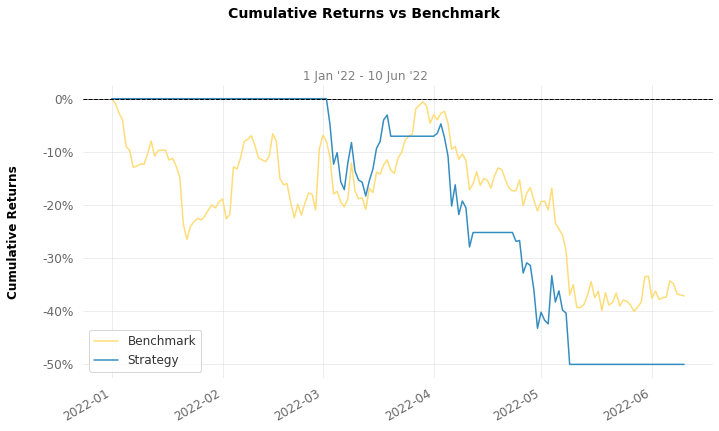

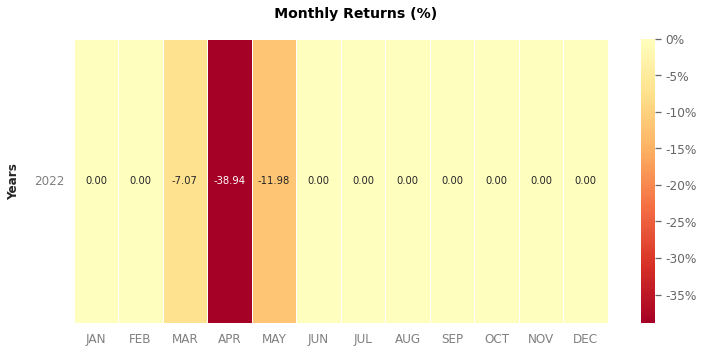

In [42]:
# Returns Visualization
i = 3
s_ret = s_ret_arr[i]

qs.plots.returns(s_ret, b_ret)
qs.plots.monthly_heatmap(s_ret)

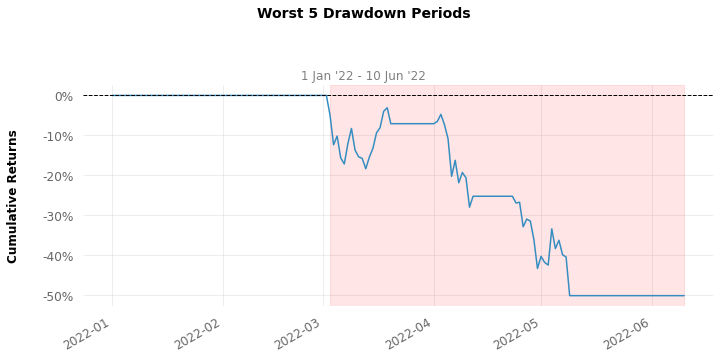

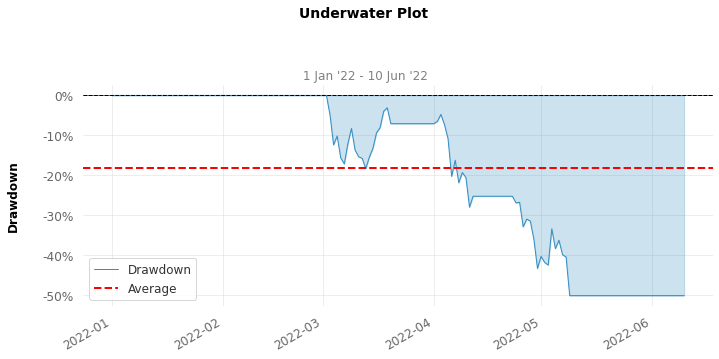

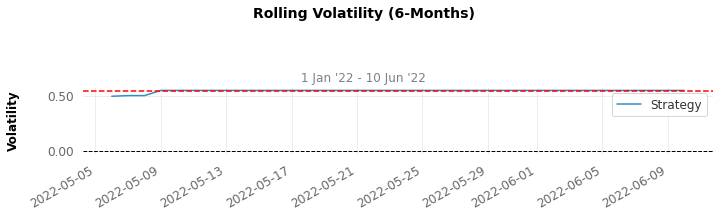

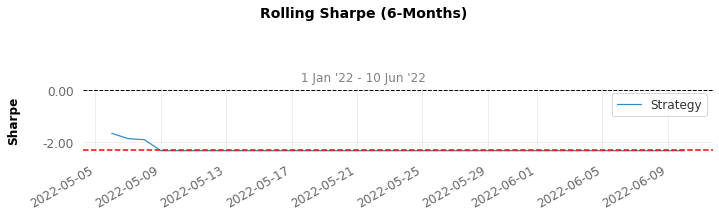

In [43]:
# Risk Visualization

qs.plots.drawdowns_periods(s_ret)
qs.plots.drawdown(s_ret)
qs.plots.rolling_volatility(s_ret)
qs.plots.rolling_sharpe(s_ret, rf=0.025)